In [1]:
file = r"C:\Users\Lenovo\Downloads\genAI_task\hhgttg.txt"

In [2]:
def process_file(file_path):
  paragraphs = []
  with open(file_path, 'r') as file:
          for line in file:
            if len(line.strip()) < 2:
              continue
            #line = "[START] " + line.strip() + " [END]"
            paragraphs.append(line.strip())
  return paragraphs

content = process_file(file)
print(len(content))

5233


In [3]:
content[11]

'of  the  people  on  it were unhappy for pretty much of the time.'

In [4]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

e:\MY projects\LangSHain\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
tokenized_content = [tokenizer.tokenize(paragraph) for paragraph in content]
tokenized_content[34]

['but',
 'it',
 'is',
 'the',
 'story',
 'of',
 'that',
 'terrible',
 'stupid',
 'catastrophe',
 'and',
 'some']

In [6]:
max_length = max([len(tokens) for tokens in tokenized_content])
max_length

33

In [7]:
vocab_set = set()
for paragraph in tokenized_content:
  vocab_set.update(paragraph)

len(vocab_set)

6142

In [8]:
token_to_index = dict()
index_to_token = dict()

token_to_index[''] = 0
index_to_token[0] = ''


for (i, token) in enumerate(vocab_set):
  token_to_index[token] = i+1
  index_to_token[i+1] = token

print(token_to_index['the'])
print(index_to_token[10])

3686
net


In [9]:
import torch

def convert_tokens(tokens):
  return torch.tensor([token_to_index[token] for token in tokens])

token_tensors = [convert_tokens(tokens) for tokens in tokenized_content]

print(token_tensors[34])

tensor([1462,  233, 2143, 3686, 4985, 5692, 4411, 5759, 4231, 5380, 5433, 1273])


In [10]:
def convert_to_y_labels(t):
  return torch.cat((t[1:], torch.tensor([0])))

convert_to_y_labels(token_tensors[34])

tensor([ 233, 2143, 3686, 4985, 5692, 4411, 5759, 4231, 5380, 5433, 1273,    0])

In [11]:
token_tensors_y = [convert_to_y_labels(t) for t in token_tensors]
token_tensors_y[34]

tensor([ 233, 2143, 3686, 4985, 5692, 4411, 5759, 4231, 5380, 5433, 1273,    0])

In [43]:
import random
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import nn

class TransformerLM(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers):
        super(TransformerLM, self).__init__()

        # Embedding layer with an additional token for [MASK]
        self.embedding = nn.Embedding(vocab_size + 1, embed_dim)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=2048)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        # Output projection layer
        self.output_layer = nn.Linear(embed_dim, vocab_size)

        # [MASK] token ID
        self.mask_token_id = vocab_size

    def forward(self, input_ids, masked_indices):
        # Embed the input IDs
        embeddings = self.embedding(input_ids)

        # Pass through Transformer Encoder
        transformer_output = self.transformer_encoder(embeddings)

        # Extract outputs for masked tokens
        masked_outputs = torch.stack([transformer_output[b, indices] for b, indices in enumerate(masked_indices)])

        # Project to vocabulary size
        logits = self.output_layer(masked_outputs)
        return logits

    def mask_tokens(self, input_paragraph):
        """
        Masks 20% of tokens randomly in the input paragraph and returns:
        - Masked input
        - Indices of masked tokens
        - Original tokens at those indices
        """
        input_len = len(input_paragraph)
        num_to_mask = max(1, int(0.2 * input_len))

        # Randomly select indices to mask
        mask_indices = random.sample(range(input_len), num_to_mask)

        # Create a copy to avoid modifying the original
        masked_input = input_paragraph[:]
        original_tokens = [masked_input[idx] for idx in mask_indices]

        # Replace tokens with [MASK]
        for idx in mask_indices:
            masked_input[idx] = self.mask_token_id

        return masked_input, mask_indices, original_tokens


In [ ]:
import matplotlib.pyplot as plt

# Model parameters
vocab_size = 10000  # Example vocabulary size
embed_dim = 512
num_heads = 8
num_layers = 6

# Initialize the model
model = TransformerLM(vocab_size, embed_dim, num_heads, num_layers)

# Training parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 1000

# Example tokenized input and target data
token_tensors = [torch.randint(0, vocab_size, (10,)) for _ in range(4)]
token_tensors_y = [torch.randint(0, vocab_size, (10,)) for _ in range(4)]

# Pad sequences
max_len = max(len(seq) for seq in token_tensors)
input_data_padded = [F.pad(seq, (0, max_len - len(seq)), value=0) for seq in token_tensors]
target_data_padded = [F.pad(seq, (0, max_len - len(seq)), value=0) for seq in token_tensors_y]

# Convert to tensors
input_data_padded = torch.stack(input_data_padded)
target_data_padded = torch.stack(target_data_padded)

# Create DataLoader
dataset = TensorDataset(input_data_padded, target_data_padded)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Track metrics for visualization
losses = []
accuracies = []

C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/1000, Loss: 9.8067, Accuracy: 0.0000
Epoch 2/1000, Loss: 9.0110, Accuracy: 0.0000
Epoch 3/1000, Loss: 8.6889, Accuracy: 0.1250
Epoch 4/1000, Loss: 8.3240, Accuracy: 0.0000
Epoch 5/1000, Loss: 8.7901, Accuracy: 0.0000
Epoch 6/1000, Loss: 7.3674, Accuracy: 0.0000
Epoch 7/1000, Loss: 9.2100, Accuracy: 0.0000
Epoch 8/1000, Loss: 7.8465, Accuracy: 0.1250
Epoch 9/1000, Loss: 7.8936, Accuracy: 0.1250
Epoch 10/1000, Loss: 7.5566, Accuracy: 0.0000
Epoch 11/1000, Loss: 6.7562, Accuracy: 0.2500
Epoch 12/1000, Loss: 7.0995, Accuracy: 0.1250
Epoch 13/1000, Loss: 6.8475, Accuracy: 0.0000
Epoch 14/1000, Loss: 6.8959, Accuracy: 0.0000
Epoch 15/1000, Loss: 6.9928, Accuracy: 0.0000
Epoch 16/1000, Loss: 6.7857, Accuracy: 0.0000
Epoch 17/1000, Loss: 5.9866, Accuracy: 0.1250
Epoch 18/1000, Loss: 7.1206, Accuracy: 0.0000
Epoch 19/1000, Loss: 6.4545, Accuracy: 0.0000
Epoch 20/1000, Loss: 6.0516, Accuracy: 0.2500
Epoch 21/1000, Loss: 6.7305, Accuracy: 0.0000
Epoch 22/1000, Loss: 5.9506, Accuracy: 0.12

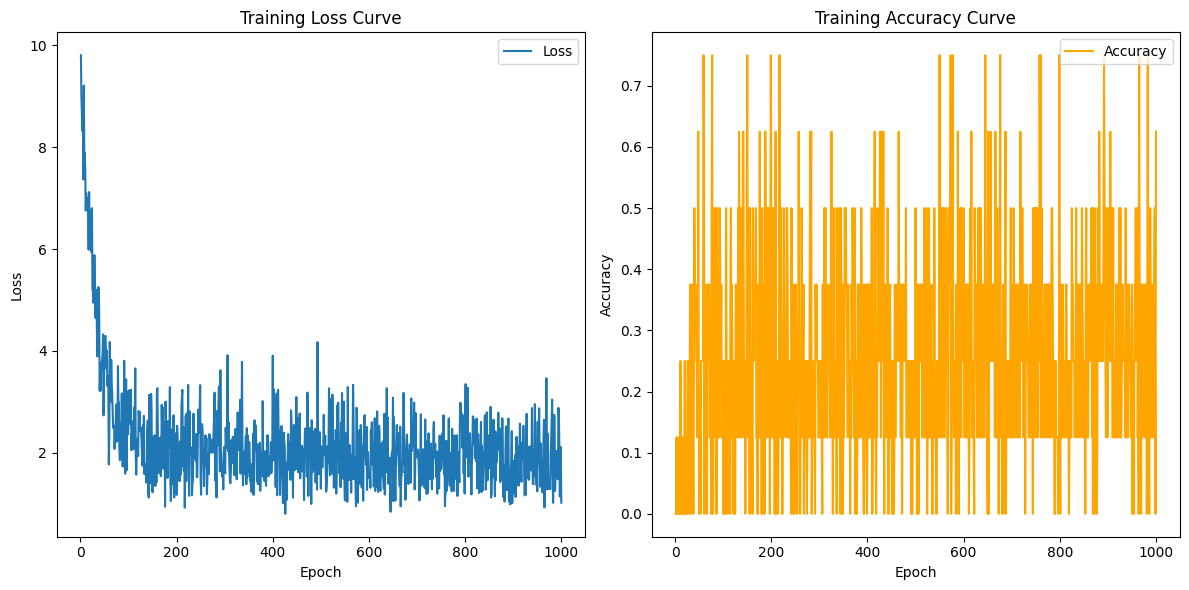

In [46]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_masked_tokens = 0

    for batch_idx, (input_ids, target_ids) in enumerate(dataloader):
        # Mask tokens in the input for the current batch
        masked_inputs, mask_indices, original_tokens = [], [], []
        for input_id in input_ids:
            masked_input, mask_idx, orig_tokens = model.mask_tokens(input_id.tolist())
            masked_inputs.append(masked_input)
            mask_indices.append(mask_idx)
            original_tokens.append(orig_tokens)

        # Convert masked inputs and indices to tensors
        masked_input_tensor = torch.tensor(masked_inputs, dtype=torch.long)
        mask_indices_tensor = [torch.tensor(idx, dtype=torch.long) for idx in mask_indices]

        # Forward pass
        logits = model(masked_input_tensor, mask_indices_tensor)

        # Reshape logits and targets
        logits = logits.view(-1, logits.size(-1))
        masked_target = []
        for idx, mask_idx in enumerate(mask_indices):
            masked_target.extend(target_ids[idx][mask_idx].tolist())
        masked_target_tensor = torch.tensor(masked_target, dtype=torch.long)

        # Ensure dimensions match for loss calculation
        assert logits.size(0) == masked_target_tensor.size(0), \
            f"Mismatch between logits ({logits.size(0)}) and targets ({masked_target_tensor.size(0)})"

        # Compute loss
        loss = criterion(logits, masked_target_tensor)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy
        _, predictions = torch.max(logits, dim=-1)
        total_correct += (predictions == masked_target_tensor).sum().item()
        total_masked_tokens += masked_target_tensor.size(0)

    # Calculate average accuracy and loss for the epoch
    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_correct / total_masked_tokens

    # Track metrics
    losses.append(avg_loss)
    accuracies.append(avg_accuracy)

    # Log metrics
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}")

# Plot training metrics
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracies, label='Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


In [47]:
vocab_size = len(token_to_index)
vocab_size

6143